# 뉴스 기사 분류 : 다중 분류 문제
- 1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터 셋을 사용했다. 이 데이터는 클래스가 많기 때문에 다중 분류(multiclass classification) 문제이다. 각 데이터 포인트가 정확히 하나의 범주로 분류되기 때문에 좀 더 정확히 말하면 단일 레이블 다중 분류(single-label, multiclass classification) 문제이다.

In [46]:
# 로이터 데이터셋 로드
from keras.datasets import reuters

# 자주 등장하는 단어 1만개로 제한
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

8,982개의 훈련 데이터와 2,246개의 테스트 데이터 확인

In [24]:
len(train_data)

8982

In [25]:
len(test_data)

2246

In [26]:
# 각 샘플은 정수 리스트이다(단어 index)
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [ ]:
# 로이터 데이터셋을 텍스트로 디코딩
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items() ])
decoded_newswire = ''.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [47]:
import numpy as np

# 데이터 인코딩
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

In [48]:
from keras.utils.np_utils import to_categorical

# 레이블 벡터화
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

레이블을 벡터로 바꾸는 방법은 두 가지이다.
1. 레이블의 리스트를 정수 텐서로 변환하는 것
  - 모델을 컴파일 하는 과정에서 spares_categorical_crossentropy 손실 함수를 사용하면 된다.
2. 원-핫 인코딩 사용
  - 원-핫 인코딩을 사용하는 경우 각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터가 된다.

In [30]:
from keras import models
from keras import layers

# 모델 정의
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])


- Dense층을 쌓으려면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있다. 
- 한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없다.
- 이는 잠재적으로 정보의 병목(information bottleneck)이 될 수 있다는 것을 의미한다.
- 현재 데이터 셋에 출력 클래스의 개수는 46개이기 때문에 중간층을 크게 가져가야 한다.
- 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목 지점처럼 작동할 수 있기 때문이다.

- 마지막 Dense 층의 크기는 46인데, 이는 이 벡터의 각 원소(각 차원)는 각기 다른 출력 클래스가 인코딩된 것이며 각 입력 샘플에 대해서 46차원의 벡터를 출력한다.
  - 즉, N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 Dense 층의 크기는 N이어야 한다.
  - 또한 마지막의 층에 softmax 활성화 함수를 사용해 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력하기 위함이다.
- 모델에서 손실 함수의 경우 categorical_crossentropy를 사용했는데, 이 함수는 두 확률 분포 사이의 거리를 측정한다. 
- 여기서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리로, 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 된다.

In [31]:
# 검증 세트 준비
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트로 사용하고 20번의 에포크로 모델을 훈련한다.

In [32]:
# 모델 훈련
history = model.fit(partial_x_train, 
                    partial_y_train,
                    epochs=20, 
                    batch_size=512, 
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 56ms/step - loss: 2.6798 - accuracy: 0.4703 - val_loss: 1.7673 - val_accuracy: 0.6230
Epoch 2/20
16/16 [==============================] - 1s 46ms/step - loss: 1.4569 - accuracy: 0.6948 - val_loss: 1.3170 - val_accuracy: 0.7260
Epoch 3/20
16/16 [==============================] - 1s 48ms/step - loss: 1.0682 - accuracy: 0.7759 - val_loss: 1.1272 - val_accuracy: 0.7550
Epoch 4/20
16/16 [==============================] - 1s 47ms/step - loss: 0.8353 - accuracy: 0.8182 - val_loss: 1.0492 - val_accuracy: 0.7610
Epoch 5/20
16/16 [==============================] - 1s 46ms/step - loss: 0.6619 - accuracy: 0.8584 - val_loss: 0.9614 - val_accuracy: 0.7960
Epoch 6/20
16/16 [==============================] - 1s 46ms/step - loss: 0.5279 - accuracy: 0.8887 - val_loss: 0.9029 - val_accuracy: 0.8100
Epoch 7/20
16/16 [==============================] - 1s 46ms/step - loss: 0.4250 - accuracy: 0.9089 - val_loss: 0.8755 - val_accuracy: 0.8200
Epoch 8/20
16

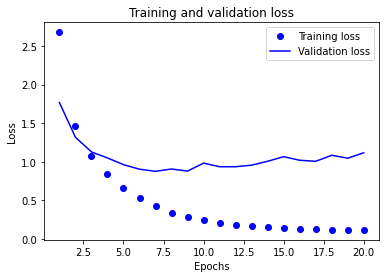

In [33]:
# 훈련과 검증 손실
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

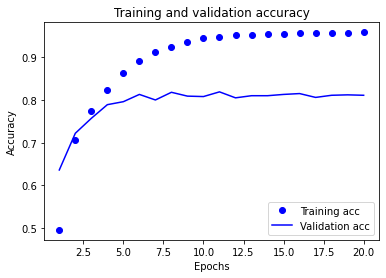

In [18]:
# 훈련과 검증 정확도
plt. clf() # 그래프 초기화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 해석
- 훈련과 검증 세트의 손실과 정확도를 그래프로 나타냈다. 
- 이를 통해 이 모델이 아홉 번째 에포크 이후에 과대 적합이 시작되는 것을 확인할 수 있다. 
- 따라서 아홉 번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가해 볼 필요가 있다.

In [34]:
# 아홉 번의 epochs로 새로운 모델 훈련
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
model.fit(partial_x_train, 
          partial_y_train, 
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 57ms/step - loss: 2.7360 - accuracy: 0.5413 - val_loss: 1.8233 - val_accuracy: 0.6560
Epoch 2/9
16/16 [==============================] - 1s 45ms/step - loss: 1.4627 - accuracy: 0.7147 - val_loss: 1.3104 - val_accuracy: 0.7180
Epoch 3/9
16/16 [==============================] - 1s 46ms/step - loss: 1.0381 - accuracy: 0.7815 - val_loss: 1.1274 - val_accuracy: 0.7620
Epoch 4/9
16/16 [==============================] - 1s 46ms/step - loss: 0.8086 - accuracy: 0.8282 - val_loss: 1.0183 - val_accuracy: 0.7940
Epoch 5/9
16/16 [==============================] - 1s 47ms/step - loss: 0.6378 - accuracy: 0.8668 - val_loss: 0.9672 - val_accuracy: 0.8060
Epoch 6/9
16/16 [==============================] - 1s 45ms/step - loss: 0.5108 - accuracy: 0.8963 - val_loss: 0.9451 - val_accuracy: 0.8060
Epoch 7/9
16/16 [==============================] - 1s 46ms/step - loss: 0.4088 - accuracy: 0.9169 - val_loss: 0.8974 - val_accuracy: 0.8140
Epoch 8/9
16/16 [===

[0.9812648892402649, 0.7920747995376587]

In [36]:
# 대략 79%의 정확도 달성
results

[0.9812648892402649, 0.7920747995376587]

새로운 데이터에 대해 예측하기

In [37]:
predictions = model.predict(x_test)

In [38]:
# predictions의 각 항목은 길이가 46인 벡터이다.
predictions[0].shape

(46,)

In [39]:
# 이 벡터의 원소의 합은 1이다.
np.sum(predictions[0])

1.0000001

In [40]:
# 가장 큰 값이 예측 클래스가 된다. 즉 가장 확률이 높은 클래스이다.
np.argmax(predictions[0])

3

# 충분히 큰 중간층을 두어야 하는 이유
- 앞에 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 hidden unit이 46개보다 많이 적어서는 안된다.

In [50]:
# 46차원보다 훨씬 작은 중간층을 두어 정보의 병목을 확인
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000, )))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, 
          partial_y_train, 
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 2s 19ms/step - loss: 2.9342 - accuracy: 0.2752 - val_loss: 2.2539 - val_accuracy: 0.3390
Epoch 2/20
63/63 [==============================] - 2s 32ms/step - loss: 1.7639 - accuracy: 0.5475 - val_loss: 1.5036 - val_accuracy: 0.6720
Epoch 3/20
63/63 [==============================] - 1s 18ms/step - loss: 1.2708 - accuracy: 0.7082 - val_loss: 1.3486 - val_accuracy: 0.6850
Epoch 4/20
63/63 [==============================] - 1s 17ms/step - loss: 1.1102 - accuracy: 0.7202 - val_loss: 1.3081 - val_accuracy: 0.6910
Epoch 5/20
63/63 [==============================] - 1s 16ms/step - loss: 1.0085 - accuracy: 0.7357 - val_loss: 1.2988 - val_accuracy: 0.6930
Epoch 6/20
63/63 [==============================] - 1s 17ms/step - loss: 0.9284 - accuracy: 0.7499 - val_loss: 1.3089 - val_accuracy: 0.6930
Epoch 7/20
63/63 [==============================] - 1s 17ms/step - loss: 0.8585 - accuracy: 0.7682 - val_loss: 1.3237 - val_accuracy: 0.7020
Epoch 8/20
63

In [51]:
results = model.evaluate(x_test, one_hot_test_labels)

71/71 [==============================] - 0s 3ms/step - loss: 2.1591 - accuracy: 0.6906


검증 정확도의 값은 69%로 10% 정도 감소되었다.
- 이런 손실의 원인 대부분은 많은 정보를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문이다.

# 정리
- N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 Dense 층의 크기는 N이어야 한다.
- 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 출력하기 위해 softmax 활성화 함수를 사용해야한다.
- 이런 문제에는 항상 범주형 crossentropy를 사용해야 한다. 이 함수는 모델이 출력한 확률 분포와 타겟 분포 사이의 거리를 최소화한다.

- 다중 분류에서 레이블을 다루는 두 가지 방법이 있다.
  - 레이블을 범주형 인코딩(또는 원-핫 인코딩)으로 인코딩하고 categorical_crossentropy 손실 함수를 사용한다.
  - 레이블을 정수로 인코딩하고 sparse_categorical_crossentropy 손실 함수를 사용한다.
- 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 정보의 병목이 생기지 않도록 해야 한다.